In [1]:
# Python imports
import sys, numpy as np
# Torch
import torch, torchvision, torch.nn as nn, torch.optim as optim
# Navigation MDP
import navigation_mdp as NvMDP
# RL utils
import rl.planning as Plan
import rl.policy as Policy
from rl.model import RewardLinear, RewardConvAE
# Utils
from utils.utils import *
from utils.plotting import NavGridViewPlotter as NvPlotter, plot_grid_data_helper
# Matplotlib
from matplotlib import cm as cm, pyplot as plt, colors as mplotcolors
%load_ext autoreload
%autoreload 2

## Gridworld 5x7

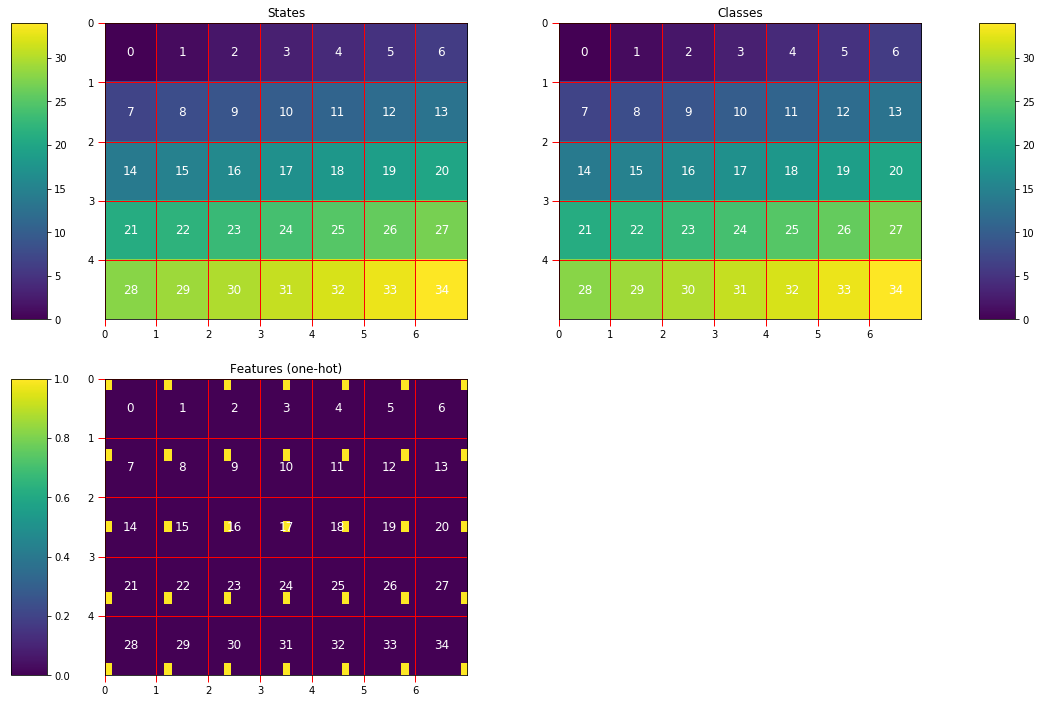

In [2]:
H, W = 5, 7
np.random.seed(5)
# Specify state space
S = NvMDP.state.DiscreteStateSpace(H, W)
goal = (H//2, W-1)
# Attach classes
class_ids = NvMDP.class_.XYClassDistribution(np.arange(H * W).reshape(H, W).tolist())().flatten()
S.attach_classes(class_ids)
# Attach features
S.attach_features(NvMDP.features.FeatureClassIndicatorOneHot(S))
# Attach rewards
S.attach_rewards(NvMDP.reward.RewardStateScalar(S, 
                    loc_to_reward_dict={goal: 0.}, class_id_to_reward_dict={}, default=0))
R = S.rewards()
# Specify dynamics
T = NvMDP.dynamics.XYDynamics(S, slip_prob=0.)
# Set goal
# S.set_terminal_status_by_loc([goal])

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
NvPlotter(S).plot_states(
    cmap=cm.viridis, ann_col="white", 
    title="States").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(2,2,2)
NvPlotter(S).plot_classes(
    cmap=cm.viridis, ann_col="white", 
    title="Classes").colorbar(where="right", pad=0.8, size="10%").grid()
plt.subplot(2,2,3)
NvPlotter(S).plot_features(
    ann=S.idxs.flatten(), cmap=cm.viridis, ann_col="white", 
    title="Features (one-hot)").colorbar(where="left", pad=0.8, size="10%").grid()
# plt.subplot(2,2,4)
# NvPlotter(S).plot_rewards(
#     cmap=cm.Blues_r, title="Rewards (Ground Truth)").colorbar(where="right", pad=0.8, size="10%").grid()

RewardLinear(
  (w): Linear(in_features=35, out_features=1, bias=False)
  (sigmoid): Sigmoid()
)


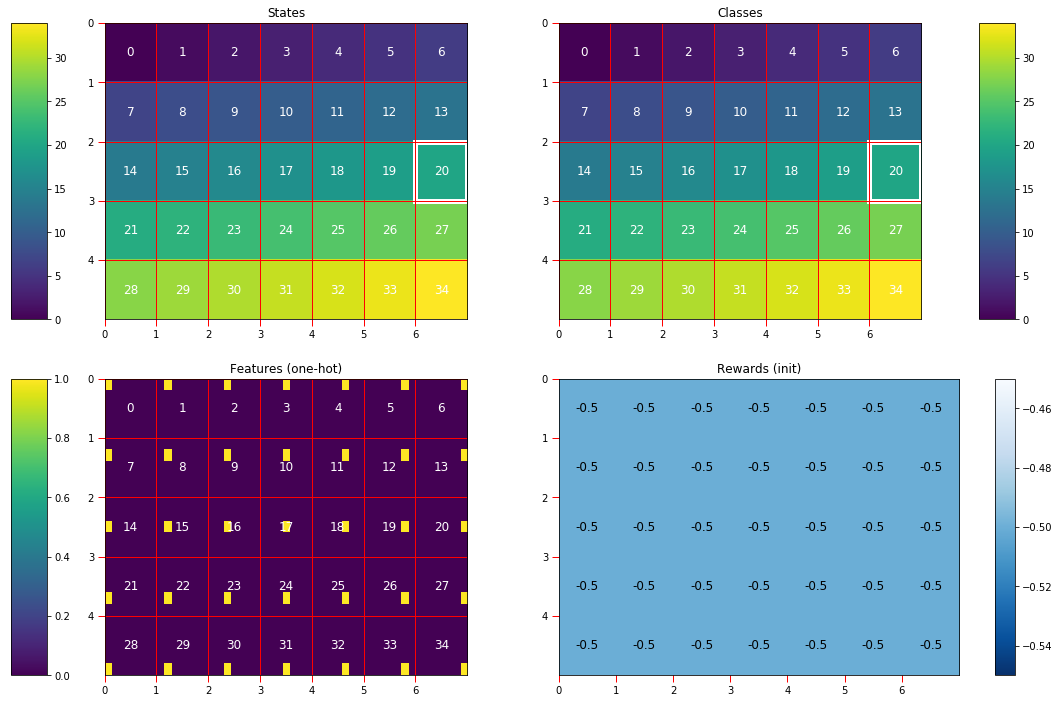

In [8]:
PHI = torch.FloatTensor(S.features())
R_model = RewardLinear(PHI[0].numpy().shape[0], lr=.2, weight_decay=0.)
R_model.init_const(0)
print(R_model)

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
NvPlotter(S).plot_states(
    cmap=cm.viridis, ann_col="white", 
    title="States").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(2,2,2)
NvPlotter(S).plot_classes(
    cmap=cm.viridis, ann_col="white", 
    title="Classes").colorbar(where="right", pad=0.8, size="10%").grid()
plt.subplot(2,2,3)
NvPlotter(S).plot_features(
    ann=S.idxs.flatten(), cmap=cm.viridis, ann_col="white", 
    title="Features (one-hot)").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(2,2,4)
NvPlotter(S).plot_array(R_model(PHI).detach().numpy().round(2), 
                           cmap=cm.Blues_r, title="Rewards (init)").colorbar(where="right", pad=0.5)

In [9]:
boltzmann_temp = 0.05
goal = S.at_loc((2,6))
log_likelihoods_history = []
s_lst_lst = [[(2,0), (2,1), (1,1), (1,2), (1,3), (1,4), (1,5), (2,5), (2,6)],
            [(2,0), (2,1), (3,1), (3,2), (3,3), (3,4), (3,5), (2,5), (2,6)]]
a_lst_lst = [T.loc_lst_to_a_lst(s_lst) for s_lst in s_lst_lst]

for _iter in range(20):
    _iter_start_time = time.time()
    R_model.zero_grad()
    VI = Plan.ValueIteration(S, R_model(PHI), T, verbose=True, log_pi=False, gamma=0.95, goal=goal)
    VI.run(150, lambda q: Policy.Boltzmann(q, boltzmann_temp=boltzmann_temp), 
           reasoning_iters=50, verbose=True, debug=False, eps=1e-4)
    
    loss = 0
    for k in range(len(s_lst_lst)):
        for i in range(len(s_lst_lst[k])-1):
            loss += -torch.log(VI.Pi[VI.get_tbl_idxs(S.at_loc(s_lst_lst[k][i]), a_lst_lst[k][i])])
    #         print(Pi[VI.get_tbl_idxs(S.at_loc((2,1+i)), "R")], loss)
    ll = np.exp(-loss.detach().item()) #* 4 # * 4 because we have 4 actions, and last terminal state policy is 0.25 everywhere
    log_likelihoods_history.append(ll)
    print(">>> Iter: {:04d} ({:03.3f}s): loss = {:09.6f}, likelihood = {:02.4f}\n\n".format(
                    _iter, time.time()-_iter_start_time, loss, ll))
    loss.backward()
    R_model.step()

Running VI [  ] VI converged @ 10.
Start reasoning @ 10.
.>>> Iter: 0000 (1.424s): loss = 43.144714, likelihood = 0.0000


Running VI [  ] VI converged @ 10.
Start reasoning @ 10.
.>>> Iter: 0001 (1.249s): loss = 24.486307, likelihood = 0.0000


Running VI [  ] VI converged @ 10.
Start reasoning @ 10.
.>>> Iter: 0002 (1.512s): loss = 10.125811, likelihood = 0.0000


Running VI [  ] VI converged @ 10.
Start reasoning @ 10.
.>>> Iter: 0003 (1.541s): loss = 05.599835, likelihood = 0.0037


Running VI [  ] VI converged @ 10.
Start reasoning @ 10.
.>>> Iter: 0004 (1.352s): loss = 03.403139, likelihood = 0.0333


Running VI [  ] VI converged @ 10.
Start reasoning @ 10.
.>>> Iter: 0005 (1.108s): loss = 02.092739, likelihood = 0.1233


Running VI [  ] VI converged @ 10.
Start reasoning @ 10.
.>>> Iter: 0006 (1.058s): loss = 01.604461, likelihood = 0.2010


Running VI [  ] VI converged @ 10.
Start reasoning @ 10.
.>>> Iter: 0007 (1.033s): loss = 01.458097, likelihood = 0.2327


Running VI [  ] 

Text(0.5, 1.0, 'Data Likelihood')

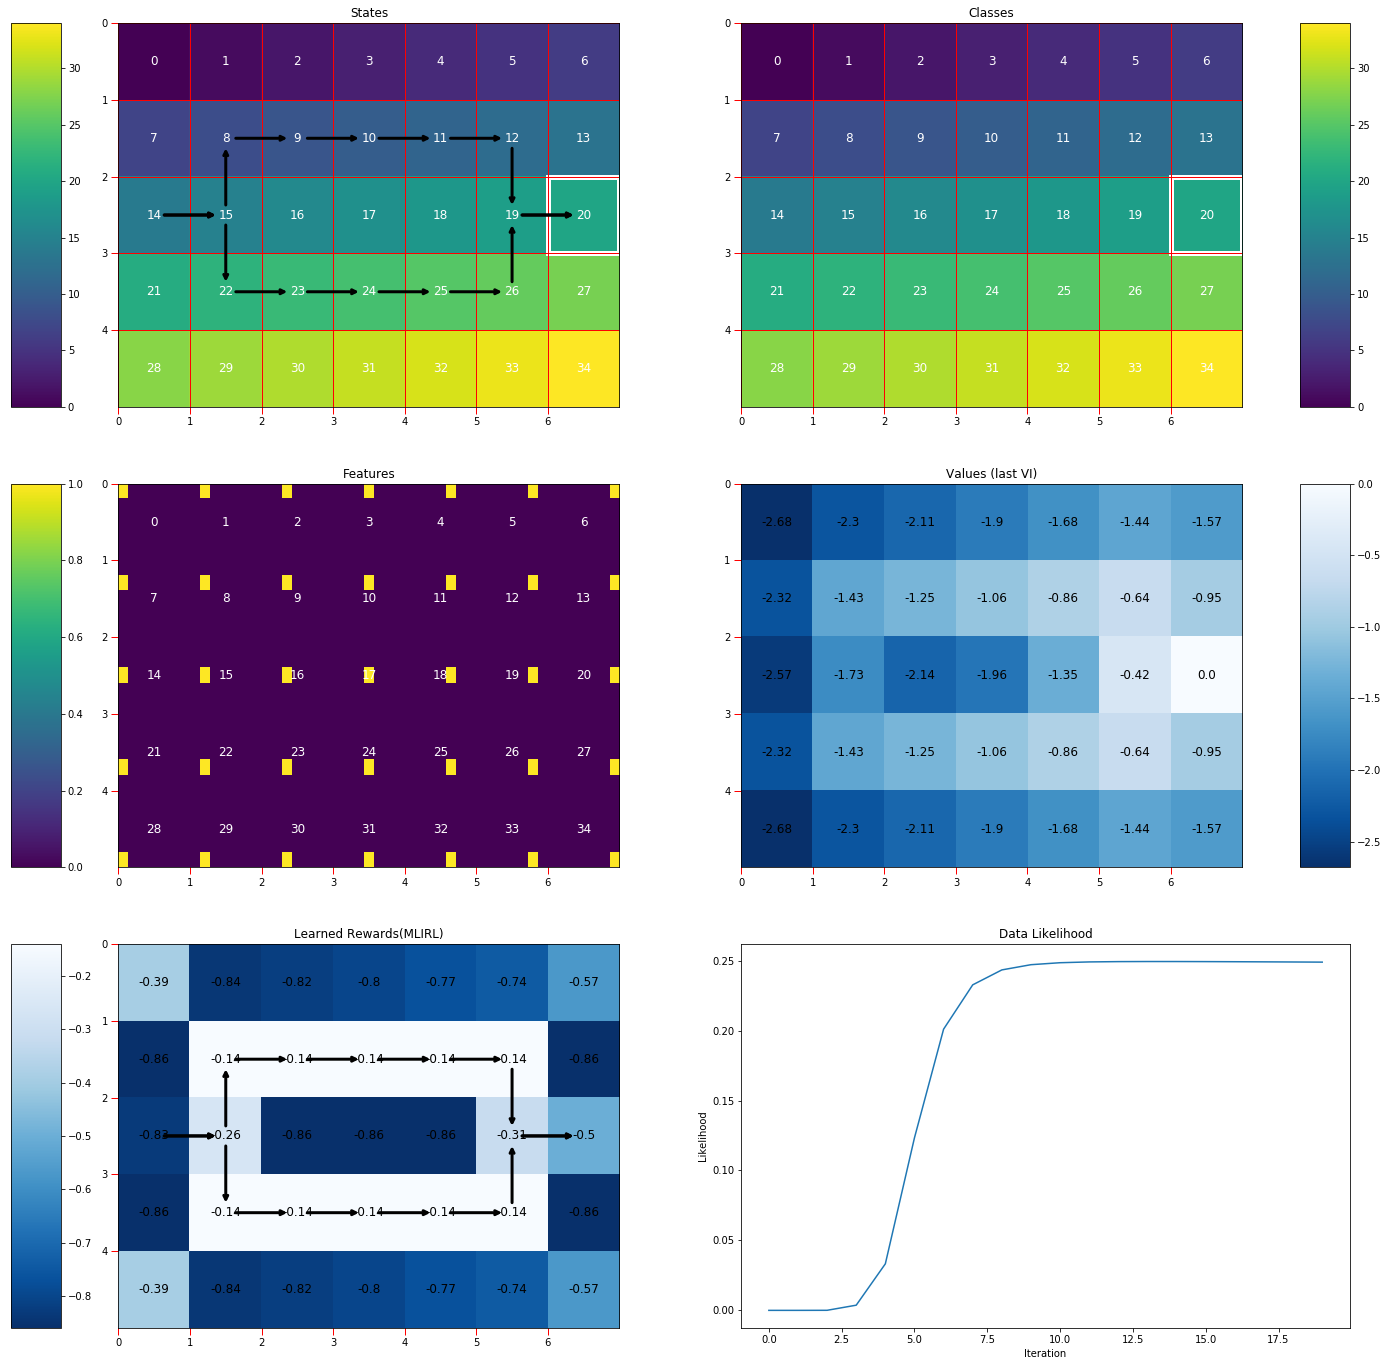

In [10]:
plt.figure(figsize=(24,24))
plt.subplot(3,2,1)
NvPlotter(S).plot_states(
    cmap=cm.viridis, ann_col="white", 
    title="States").colorbar(where="left", pad=0.8, size="10%").grid().add_pixel_trajectories(
    [[(s[1], s[0]) for s in s_lst ] for s_lst in s_lst_lst ], 
    arrow_props={"lw": 3, "color": "black", "shrinkB":10, "shrinkA":10})
plt.subplot(3,2,2)
NvPlotter(S).plot_classes(
    cmap=cm.viridis, ann_col="white", 
    title="Classes").colorbar(where="right", pad=0.8, size="10%").grid()
plt.subplot(3,2,3)
NvPlotter(S).plot_features(
    ann_col="white", cmap=cm.viridis).colorbar(where="left", pad=.8, size="10%")
plt.subplot(3,2,4)
NvPlotter(S).plot_array(VI.V.detach().numpy().round(2),
                           cmap=cm.Blues_r, title="Values (last VI)").colorbar(where="right", pad=0.8, size="10%")
plt.subplot(3,2,5)
NvPlotter(S).plot_array(R_model(PHI).detach().numpy().round(2), 
                        cmap=cm.Blues_r, title="Learned Rewards(MLIRL)").colorbar(where="left", pad=0.8, size="10%").add_pixel_trajectories(
    [[(s[1], s[0]) for s in s_lst ] for s_lst in s_lst_lst ], 
    arrow_props={"lw": 3, "color": "black", "shrinkB":10, "shrinkA":10})
plt.subplot(3,2,6)
plt.plot(range(len(log_likelihoods_history)), log_likelihoods_history)
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.title("Data Likelihood")
# plt.savefig("./figures/mlirl_gw_5x7_one_hot__traj_2_turns")